Tutorial to generate random walks in Bitcoin/USD and Ethereum/USD prices that reflects ETH/USD's correlation to BTC/USD movements, as well as the mean reversion and non-normality of return distributions in each series.

This can be used to generate random walks for multiple series with various correlations for purposes such as:
- Performance of any price asset corelated to any other asset or metric
- MarketCap (or MarketCap/TVL ratio) correlated to any metric such as BTC price, revenue, NFT trading volume, etc
- TVL in the protocol correlated to any metric
- Percentage of ciculating supply staked correlated to any metric
- Daily usage or trading volumes correlated to any metric

These distributions can feed into simulation frameworks like cadCAD or radCAD which provide an easy framework for running simulations of complex systems. This repo is a complement to these frameworks, not a replacement for these frameworks, as frameworks like cadCAD or radCAD require the user to specify the randomness or patterns by which system inputs evolve each step.

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import brownian_motion_generator as bmg # Assumes brownian_motion_generator.py is in the currnent path directory

import matplotlib.pyplot as plt


In [2]:
#Fetch market prices for raw data
def coin_gecko_prices(coin, against='usd', days=1460):
    url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart?vs_currency={against}&days={days}'.format(coin,against,days) 
    r = requests.get(url)
    df = pd.DataFrame(r.json()['prices'],columns=['unix',f'{coin}_{against}'])
    return df

btc = coin_gecko_prices('bitcoin')
eth = coin_gecko_prices('ethereum')
df = pd.merge(btc,eth,how='left',on='unix').dropna(how='any')
df


,unix,bitcoin_usd,ethereum_usd
0,1549929600000,3631.444540,120.970262
1,1550016000000,3633.965047,122.542089
2,1550102400000,3610.062273,122.094130
3,1550188800000,3589.661830,120.592174
4,1550275200000,3601.229191,121.572278
...,...,...,...
1455,1675641600000,22946.286579,1631.372523
1456,1675728000000,22786.483006,1617.144163
1457,1675814400000,23294.913648,1672.822678
1458,1675900800000,22947.507829,1651.408379


In [3]:
#Series should be mean stationary - in this case of price series, convert them to log normal returns
#Learn more: https://en.wikipedia.org/wiki/Stationary_process
df['btc_ln_return'] = np.log(df['bitcoin_usd'] / df['bitcoin_usd'].shift(1))
df['eth_ln_return'] = np.log(df['ethereum_usd'] / df['ethereum_usd'].shift(1))
df = df.dropna(how='any')
df


,unix,bitcoin_usd,ethereum_usd,btc_ln_return,eth_ln_return
1,1550016000000,3633.965047,122.542089,0.000694,0.012910
2,1550102400000,3610.062273,122.094130,-0.006599,-0.003662
3,1550188800000,3589.661830,120.592174,-0.005667,-0.012378
4,1550275200000,3601.229191,121.572278,0.003217,0.008095
5,1550361600000,3622.591653,122.938608,0.005914,0.011176
...,...,...,...,...,...
1455,1675641600000,22946.286579,1631.372523,-0.017027,-0.021767
1456,1675728000000,22786.483006,1617.144163,-0.006989,-0.008760
1457,1675814400000,23294.913648,1672.822678,0.022068,0.033851
1458,1675900800000,22947.507829,1651.408379,-0.015026,-0.012884


In [4]:
#Approximate the distribution parameters of each series
#Here we will use a custom distribution for each: other options include 'normal' or 'laplace'
#Learn more: https://www.sixfigureinvesting.com/2016/03/modeling-stock-market-returns-with-laplace-distribution-instead-of-normal
OU_params_btc = bmg.estimate_OU_params(df['btc_ln_return'].values, distribution_type='custom')
OU_params_eth = bmg.estimate_OU_params(df['eth_ln_return'].values, distribution_type='custom')


In [5]:
# OPTIONALLY: override the gamma (long term mean) of the expected distribution
#For example if you wanted to ignore the historical trend in prices you could do so by setting price changes to 0 gamma
# OU_params_btc.gamma = 0
# OU_params_eth.gamma = 0


In [6]:
TIMESTEPS = 90 # number of timesteps for each run/simulation. In this case, simulating the next N trading days
RUNS = 1_000 # number of runs/simulations/random-walks to generate. Each run will be for the number of TIMESTEPS set above

OU_params = (
    OU_params_btc,
    OU_params_eth,
)

#Random walks will be generated for each series correlated to the first provided series based on the provided correlation matrix
#In this case, ETH's random walks will be generated approximating ETH's realized correlation to BTC
correlations = df[
    ['btc_ln_return',
     'eth_ln_return',
    ]
].corr().values[0]

OU_procs = bmg.simulate_corr_OU_procs(TIMESTEPS, OU_params, RUNS, rho=correlations)
#OU_procs is a numpy array of shape (RUNS, TIMESTEPS, # of variables being simulated)
OU_procs.shape


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 6277.51it/s]


(1000, 90, 2)

In [7]:
#Turn the numpy array into a dataframe
runs,timesteps,procs = OU_procs.shape
OU_procs_arr = np.column_stack((np.repeat(np.arange(runs),timesteps),OU_procs.reshape(runs*timesteps,-1)))
walks = pd.DataFrame(OU_procs_arr,
                     columns=[
                         'run',
                         'btc_ln_return',
                         'eth_ln_return',
                     ])

walks['run'] = walks['run'].astype('int') + 1
walks['timestep'] = walks.groupby('run').cumcount() + 1
walks


,run,btc_ln_return,eth_ln_return,timestep
0,1,0.001231,0.001743,1
1,1,0.007093,0.008911,2
2,1,0.006334,0.008695,3
3,1,0.004562,0.009109,4
4,1,0.001027,0.029906,5
...,...,...,...,...
89995,1000,-0.001523,0.000499,86
89996,1000,0.005717,0.012080,87
89997,1000,0.003138,0.006154,88
89998,1000,0.002696,0.005724,89


At this point, we not have RUNS number of random walks, each for TIMESTEPS number of steps, for each variable.

Our random walks are ready to use for risk analsysis, scenario testing, Monte Carlo anaysis, and for feeding into existing simulation/modeling frameworks such as cadCAD or radCAD.

The below steps after this point are optional and not strictly part of generating the brownian motion random walks themselves.


OPTIONAL:

In this tutorial, we are dealing with daily returns. If we want to visualize the cumulative path prices take, we need to aggregate daily changes into cumulative changes.


In [8]:
#A convenient aspect of log normal returns is that a cumulative period's change is equal to the sum of each period's change
walks['cumulative_btc_ln_return'] = np.exp(walks.groupby('run')['btc_ln_return'].transform('cumsum'))
walks['cumulative_eth_ln_return'] = np.exp(walks.groupby('run')['eth_ln_return'].transform('cumsum'))

walks['btc_index'] = walks['cumulative_btc_ln_return'] * 100 # index to 100 starting value
walks['eth_index'] = walks['cumulative_eth_ln_return'] * 100 # index to 100 starting value


In [9]:
#Check the distribution of cumulative price movements at the final timestep of each run/simulation
walks[walks['timestep'] == TIMESTEPS][['btc_index','eth_index']].describe()


,btc_index,eth_index
count,1000.000000,1000.000000
mean,115.006330,123.541654
std,29.475902,40.366021
min,49.337908,41.999361
25%,93.529837,94.412299
50%,110.917625,118.009010
75%,133.347336,147.800319
max,277.223827,322.540670


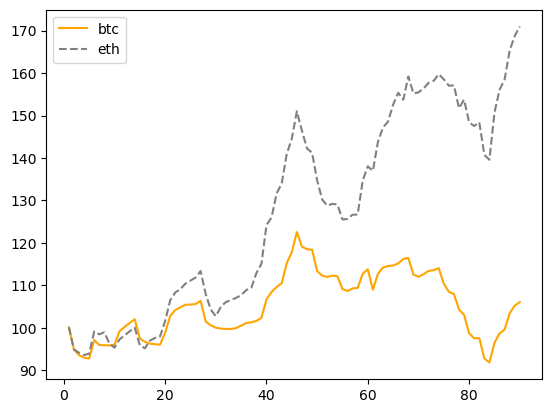

In [10]:
#Chart the random walks from any given run
run = 10
data = walks[walks['run'] == run]

step = data['timestep']

btc = data['btc_index']
eth = data['eth_index']

plt.plot(step, btc, label = "btc", color='orange', linestyle="-")
plt.plot(step, eth, label = "eth", color='gray', linestyle="--")

plt.legend()
plt.show()


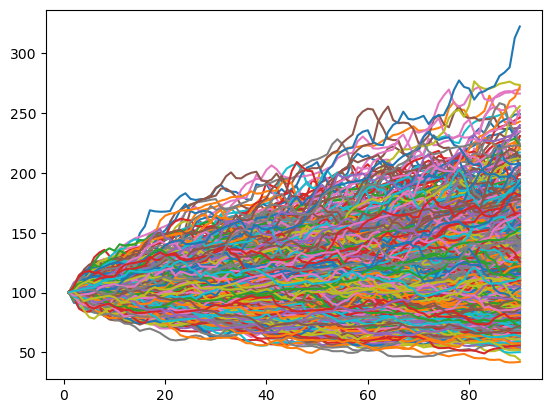

In [11]:
#Chart all random walks for a given series (ie either BTC or ETH)
for run in range(1,RUNS+1):
    data = walks[walks['run'] == run]

    step = data['timestep']
#     index = data['btc_index']
    index = data['eth_index']

    plt.plot(step, index, linestyle="-")
    
plt.show()
